# MNIST Sample

This notebook creates a sample model for MNIST using Tensorflow and SenseTheFlow.

As a sample, it is an overkill that will use Keras Resnet50 implementation.

In [1]:
!pip3 install --upgrade git+https://github.com/gpascualg/SenseTheFlow.git@testing

  Cloning https://github.com/gpascualg/SenseTheFlow.git (to revision testing) to /tmp/pip-req-build-nl2c58ya
  Running command git clone -q https://github.com/gpascualg/SenseTheFlow.git /tmp/pip-req-build-nl2c58ya
  Running command git checkout -b testing --track origin/testing
  Switched to a new branch 'testing'
  Branch 'testing' set up to track remote branch 'testing' from 'origin'.
  Created wheel for SenseTheFlow-gpascualg: filename=SenseTheFlow_gpascualg-0.0.5-py3-none-any.whl size=53439 sha256=40ee78a38a9da9086895b3438f3b1601b4f3200fd78e133433fd8774812bfe9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-n5gkiejt/wheels/99/d6/76/f4b68f177bc237b557fcca90bf7e34ac45c341150f046318b4
Successfully built SenseTheFlow-gpascualg
  Attempting uninstall: SenseTheFlow-gpascualg
    Found existing installation: SenseTheFlow-gpascualg 0.0.5
    Uninstalling SenseTheFlow-gpascualg-0.0.5:
      Successfully uninstalled SenseTheFlow-gpascualg-0.0.5


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from SenseTheFlow.experiment import Experiment, Mode, ExperimentOutput, keras_weight_path, ExperimentHook, Hookpoint, default_config
from SenseTheFlow.layers import utils
from SenseTheFlow.models.resnet import ResNet50

## Define the Model

Models are now sub-classes from `tf.keras.Model`. This is to make user code and the library itself compatible with future Tensorflow 2.0 usage.

Such models should:
* Define layers in its `__init__(self, mode, params)` constructor. The easiest way to do so would be by using either `tf.keras.layers` or `keras.layers`.
* Call layers in its `call(self, x, y, mode, params)` method.

The `call` method must return a `ExperimentOutput` instance. Its property `loss` must be different from `None`, either a tensor or a constant.

In [3]:
class MNIST(tf.keras.Model):
    def __init__(self, mode, params):
        # Always call `super` constructor
        super(MNIST, self).__init__()
        
        # Define layers
        self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', data_format=params['data_format'])
        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', data_format=params['data_format'])
        
        # Example on how to add L2 to a layer, no need to manually touch the loss term, it will be automatically used
        # I use 3 filters as resnet requires 3 channels
        self.conv3 = tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation='relu', padding='same', data_format=params['data_format'], 
                                           kernel_regularizer=tf.keras.regularizers.l2(0.001)) 
        
        # Make sure keras uses our data_format
        tf.keras.backend.set_image_data_format(params['data_format'])
        
        # If you intend to train this resnet, you can leave it as is
        # Otherwise, make sure to set "trainable_bn=False, l2=None"
        self.resnet = ResNet50(params['data_format'], trainable_bn=mode==Mode.TRAIN, l2=0.001)
        
        # Note this is a top-less resnet, it doesn't have pooling/dense layers
        self.pool = tf.keras.layers.GlobalAveragePooling2D(data_format=params['data_format'])
        self.dense = tf.keras.layers.Dense(10)
        
        # Optimizer and other params
        self.params = params
        self.mode = mode
        
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # OPTIMIZER NO LONGER HERE
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        # Let's keep an average of the loss
        # All metrics are automatically reset on every epoch, even if you don't do it yourself
        self.loss_avg = tf.keras.metrics.Mean()
        
    def call(self, inputs, training, step):
        if self.mode != Mode.TEST:
            x, y = inputs
        else:
            x = inputs
            
        # Make sure the image is in the correct data format, we get it in channels_last 
        x = utils.to_data_format(x, 'channels_last', params['data_format'])
            
        # Call layers
        outputs = self.conv1(x)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        outputs = self.resnet(outputs)
        outputs = self.pool(outputs)
        logits = self.dense(outputs)
        
        # When `mode == Mode.TEST`, `y` will be None
        loss = 0.0
        if self.mode != Mode.TEST:
            # Compute loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(loss)
            
            # Update average
            self.loss_avg.update_state(loss)
            
        # Summary examples
        if tf.equal(tf.math.floormod(step, self.params['summary_steps']), 0):
            with tf.device("cpu:0"):
                tf.summary.scalar('loss', loss, step=step)
                
                # Include the loss average
                tf.summary.scalar('loss/avg', self.loss_avg.result(), step=step)
                
                # We should reset this here, but tensorflow won't like it and it will be
                #  ignored. So, we are doing it later and more convoluted...
                # self.loss_avg.reset_states()
        
        # `call` must return `ExperimentOutput`, and it must be constructed as a "key=value" object
        return ExperimentOutput(
            outputs={
                'probabilities': tf.nn.softmax(logits),
                'number': tf.argmax(logits)
            },
            loss=loss
        )
    
    # If this method exists, it is automatically called once an epoch is done
    # It is specially useful during evaluations, as it allows to register the
    #  last accumulated value of metrics
    def on_epoch(self, step):
        tf.summary.scalar('loss/avg', self.loss_avg.result(), step=step)

    # This will be manually hooked later, basically resets all metrics to its
    #  initial state. It is usually done at the same moment as when the summaries are
    #  saved
    def reset(self, *args, **kwargs):
        self.loss_avg.reset_states()

## Define some params

In [4]:
params = {
    'model_name': 'mnist-test',
    'learning_rate': 3e-4,
    'batch_size': 128,
    'summary_steps': 1000,
    'data_format': 'channels_first'
}

## Define the data pipeline

It can be done in multiple ways, the only restriction is for your `dataset_fn` to return a `tf.Dataset` instance. Here, we will use `Keras` to directly obtain images and labels, but one could read from disk or whatever other option.

Here using a generator might not be the best idea (performance-wise), as we have all data already loaded into RAM. However, the general case will be generators, thus it is the pipeline used.

In [5]:
def mnist_generator(mode):
    data_train, data_test = tf.keras.datasets.mnist.load_data()
    x, y = data_train if mode == Mode.TRAIN else data_test
    
    for image, label in zip(x, y):
        # Here we simply yield two values, but you could easily construct other returns.
        # More examples are provided below
        yield image[..., np.newaxis], label
        
# `dataset_fn` always receives the run `mode`.
def dataset_fn(mode, params):
    # Create a dataset from a geneator
    dataset = tf.data.Dataset.from_generator(
        generator=lambda: mnist_generator(mode), 
        output_types=(tf.float32, tf.int32),
        output_shapes=([28, 28, 1], None)
    )

    # Batch inputs, make sure all batches are equal-sized (drop_remainder=True)
    dataset = dataset.batch(params['batch_size'], drop_remainder=True)
    # Prefetch some batches
    dataset = dataset.prefetch(8)
    # Repeat for 100 epochs, leave blank to repeat indefinately
    dataset = dataset.repeat(1)
    # Return the dataset
    return dataset

In [6]:
# The new way to tell TF not to use all GPUs but only the exact amount needed
# The next cell will attempt to use GPU space if executed (even if told to use CPU), so do it now
#  otherwise it would be fine to do it just before running the model

# Default config does all of this for you
default_config()

2 Physical GPUs, 2 Logical GPUs


tf.Tensor(5, shape=(), dtype=int32)


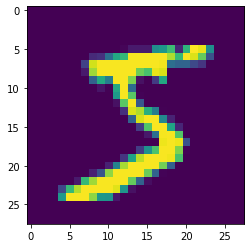

In [7]:
# Errors in the above functions are particularly hard to debug once in the network
# you can manually inspect everything works like this

with tf.device('/cpu:0'):
    dataset = dataset_fn(Mode.TRAIN, params)
    for x, y in dataset:
        for batch in range(params['batch_size']):
            print(y[batch])
            plt.imshow(x[batch, ..., 0])
            break
        break

In [8]:
!nvidia-smi

Tue Nov 10 23:30:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 418.43       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   42C    P2    61W / 250W |    157MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:04:00.0 Off |                  N/A |
| 34%   49C    P2    56W / 250W |    147MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## Define the experiment

Experiments are executed in two steps:

1. Experiment discovery: That is, given the experiment name (or model name) find the corresponding saved checkpoint (if any). This process might not be completed immediately due to:
  * Remote execution, when the model has to be fetched from the main data-storage
  * Local jupyter execution, when the model is selected from the drop-down
  
2. Experiment execution: Calling train/eval/test and waiting for the results. SenseTheFlow is asynchronous by default, which means that all executions are done in a background thread. Some mechanisms are provided to block until certain events
  * `wait_ready` might be used to wait until the experiment actually starts running (waits until tensorflow has setup the GPU memory and starts iterating)
  * `wait_for` can be used to wait for a certain number of steps or seconds
  * `wait` can be used to block until the experiment completely finishes
  
Alternatively, asynchronous execution can be turned off by specifying `sync=True` to any of the calls above.

In [9]:
# As always, you may not want debug messages

import logging
logger = tf.get_logger()
logger.setLevel(logging.DEBUG)

In [10]:
# By default everything is run in Graph mode (ie. compiled, fast). It can be optionally executed eagerly (step by step) by using
#tf.config.experimental_run_functions_eagerly(True)

# Supply the name, model CLASS, params and where to write
experiment = Experiment(params['model_name'], MNIST, params=params, persistent_path=os.path.join('/tmp/', params['model_name']))
# Tell it which GPU to use
experiment.assign_gpu(1)
# And search for existing models
discovery = experiment.run_local(prepend_timestamp=True)

# A selection menu will drop down, continuing raise an error unless something is selected

Select(options=(('-', None), (' |- Create new model', -1), (' |- Remove previous and create new', -2), ('-', N…

In [11]:
# There are two special methods that might be called pre/post initialization of the network
#  * Pre-initialization is useful to manually load another checkpoint (aside from the one of this same model,
#    which is loaded automatically)
#  * Post-initialization is used to load some keras-specific weights, as is the case with 
#    resnet and such models

def pre_initialize_fn(experiment, model, mode, ckpt):
    # Also, you can add here some special hooks that, for example, call methods of the model itself
    # We reset all metrics (only during mode=Mode.TRAIN!) with the following hook
    experiment.add_hook(Hookpoint.LOOP, ExperimentHook('reset', model.params['summary_steps'], model.reset, concurrent=False, mode=Mode.TRAIN))

    # You can also trigger evaluations here (TRAIN only!)
    # Make sure they are after a checkpoint is done. Currently it requires specifying the same amount of
    #  steps. In the future you will be able to do "experiment.get_hook('checkpoint').steps"
    #experiment.add_hook(Hookpoint.LOOP, ExperimentHook('eval', 1000, lambda *args, **kwargs: experiment.eval(dataset_fn), mode=Mode.TRAIN))
    
    # We can manually load another chekpoint by manually doing so
    # NOTE that SenseTheFlow will still load the latest checkpoint after, an schematic is provided below
    """
    ckpt = tf.train.Checkpoint(net=model)
    warm_start = tf.train.latest_checkpoint('/path to some othe model whatsoever')
    print('Warm starting from {}'.format(warm_start))
    restore = ckpt.restore(warm_start)
    return restore, restore.assert_existing_objects_matched # See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint for assert_existing_objects_matched
    """

def post_initialize_fn(experiment, model, mode, last_checkpoint):
    # In case the model has an existing checkpoint, it will have already been loaded by now
    #  which means Resnet is already loaded
    # If we allowed the resnet to be modified it is of high importance to return here, otherwise
    #  we will load over the trained weights the original resnet
    if last_checkpoint:
        print('Skip RESNET load')
        return
    
    # Otherwise, load the weights
    print('Loading resnet')
    model.resnet.load(keras_weight_path('resnet50'), by_name=True)

# Notify of the selected model
experiment.on_discovered(discovery)

# Call train, by default will:
#  * checkpoint_steps=1000, saves the model every 1000 steps
#  * summary_steps=100, saves summaries every 100 steps
#  * config=None, which means it will *not* use all gpus, but gradually expand memory
# By default the model is executed in a background thread, which might be a BAD idea
#  if you have errors and want to find them
#  use sync=True to block and run normally
#context = experiment.train(dataset_fn, pre_initialize_fn=pre_initialize_fn, post_initialize_fn=post_initialize_fn)

# Wait until it actually is running
#context.wait_ready()

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# OPTIMIZER CREATED HERE
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])

for _ in range(100):
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # OPTIMIZER PASSED TO TRAIN FUNCTION (EVAL/TEST can also receive it, but will be ignored)
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    print("======================================= TRAIN")
    model = experiment.train(dataset_fn, optimizer, pre_initialize_fn=pre_initialize_fn, post_initialize_fn=post_initialize_fn, checkpoint_steps=None, checkpoint_on_epoch=True, sync=True)
    print("======================================= EVAL")
    model = experiment.eval(dataset_fn, sync=True)
    # model = experiment.eval(dataset_fn, optimizer, sync=True) # Also OK, suppresses warnings for optimizer related (non)-issues

======================================= TRAIN


Initializing from scratch.
Loading resnet


Saved checkpoint for step 468: /tmp/20201110-233009/mnist-test/ckpt-1


Restored iter 468 from /tmp/20201110-233009/mnist-test/ckpt-1


======================================= TRAIN


A hook with the name 'reset' and mode 'Mode.TRAIN' already exists in 'Hookpoint.LOOP'
Restored iter 468 from /tmp/20201110-233009/mnist-test/ckpt-1
Skip RESNET load


Saved checkpoint for step 936: /tmp/20201110-233009/mnist-test/ckpt-2


Restored iter 936 from /tmp/20201110-233009/mnist-test/ckpt-2


======================================= TRAIN


A hook with the name 'reset' and mode 'Mode.TRAIN' already exists in 'Hookpoint.LOOP'
Restored iter 936 from /tmp/20201110-233009/mnist-test/ckpt-2
Skip RESNET load


Saved checkpoint for step 1404: /tmp/20201110-233009/mnist-test/ckpt-3


Restored iter 1404 from /tmp/20201110-233009/mnist-test/ckpt-3


======================================= TRAIN


A hook with the name 'reset' and mode 'Mode.TRAIN' already exists in 'Hookpoint.LOOP'
Restored iter 1404 from /tmp/20201110-233009/mnist-test/ckpt-3
Skip RESNET load


Saved checkpoint for step 1872: /tmp/20201110-233009/mnist-test/ckpt-4


Restored iter 1872 from /tmp/20201110-233009/mnist-test/ckpt-4


======================================= TRAIN


A hook with the name 'reset' and mode 'Mode.TRAIN' already exists in 'Hookpoint.LOOP'
Restored iter 1872 from /tmp/20201110-233009/mnist-test/ckpt-4
Skip RESNET load


Saved checkpoint for step 2340: /tmp/20201110-233009/mnist-test/ckpt-5


Restored iter 2340 from /tmp/20201110-233009/mnist-test/ckpt-5


======================================= TRAIN


A hook with the name 'reset' and mode 'Mode.TRAIN' already exists in 'Hookpoint.LOOP'
Restored iter 2340 from /tmp/20201110-233009/mnist-test/ckpt-5
Skip RESNET load


## Waiting

An experiment can be waited, in general, by calling any of `wait_ready` or `wait`. As opposed to waiting on a context, waiting on an experiment will wait for all individual runs to end (for example, wait for both train and eval to end)

It is encoraged to call `wait_ready` before continuing, to ensure the context is registered.

In [ ]:
experiment.wait_ready() # equivalent to context.wait_ready() above
# experiment.wait()

## Further using the context

The training `context` above, inside `once_discovered`, can be recovered with:

In [ ]:
# As it is the first and only call to train, out context is in position [0] of Mode.TRAIN
# Further calls would be in next positions, ordered by call order always

# If, by whatever reason, you lose track of your context, you can get it again by
context = experiment.get_context(Mode.TRAIN)[0]

# You can also get eval contexts
# last_eval_context = experiment.get_context(Mode.EVAL)[-1]

In [ ]:
# Display TQDM vars again
context.reattach()

In [ ]:
# Now we can do either of this:

# context.save()
# context.reattach() # Redraws the TQDM bars
# context.stop() # Stops training

# Wait until it finishes, can exit waiting by pressing stop or CTRL+C, training won't be affected.
# context.wait()

context.stop()

In [13]:
# Once a context ends or is stopped, you can retrieve the model with the latest parameters trained
model = context.model()

NameError: name 'context' is not defined

In [14]:
# You can also, at any moment, ask for a freshly loaded model from the last checkpoint done
last_checkpoint_model = context.load_model_from_last_checkpoint()

# For instance, you can do
with tf.device('/gpu:0'):
    for x, y in dataset_fn(Mode.TEST, params):
        print(y, last_checkpoint_model(x, training=False, step=0))

NameError: name 'context' is not defined